# Homework 3:

In this notebook, we've learned about some basic convolutional networks and trained one on CIFAR-10 images.  It did ... OK.  There is significant overfitting of this model.  There are some ways to address that, but we didn't have time to get into that in this session.

Meanwhile, your homework (part 1) for this week is to try to train the model again but with a different architecture.  Change one or more of the following:
- The number of convolutions between downsampling
- The number of filters in each layer
- The initial "patchify" layer
- Another hyper-parameter of your choosing


And compare your final validation accuracy to the accuracy shown here.  Can you beat the validation accuracy shown?

For full credit on the homework, you need to show (via text, or make a plot) the training and validation data sets' performance (loss and accuracy) for all the epochs you train.  You also need to explain, in several sentences, what you changed in the network and why you think it makes a difference.

In [1]:
## Prepare train and test data loaders
import torch, torchvision
from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
    root="ai-science-training-series/03_advanced_neural_networks/",
    train=True,
    download=True,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(), ## Image augmentation list, Do all tihs in a row. 
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), ## Adding noise to images 
    ])
)

test_data = torchvision.datasets.CIFAR10(
    root="ai-science-training-series/03_advanced_neural_networks/",
    train=False,
    download=False,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=True, 
    num_workers=4)
val_dataloader = torch.utils.data.DataLoader(validation_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=4)


/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

Files already downloaded and verified


In [2]:
## Define helper function to Wrapp data and move it to GPU

dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)


In [3]:
## Define downsampler, Convoluiton bloks and Classifier

from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):


        return self.downsample(self.norm(inputs))
        
        

class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



In [4]:
### Define inputs for original model 
og_initial_filters = 32
og_n_stages = 4
og_blocks_per_stage = 2

og_model = Classifier(og_initial_filters,og_n_stages,og_blocks_per_stage)

from torchinfo import summary

print(summary(og_model, input_size=(batch_size, 3, 32, 32)))



Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 32, 32, 32]         128
├─LayerNorm: 1-2                         [128, 32, 32, 32]         65,536
├─Sequential: 1-3                        [128, 256, 4, 4]          --
│    └─ConvNextBlock: 2-1                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-2               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-3                  [128, 128, 32, 32]        4,224
│    │    └─Conv2d: 3-4                  [128, 32, 32, 32]         4,128
│    └─ConvNextBlock: 2-2                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-5                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-6               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-7                  [128, 128, 32, 32] 

In [5]:
## Define function for evaluation and training of one epoch

def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()
            
    loss /= num_batches
    correct /= (size*batch_size)
    
    accuracy = 100*correct
    return accuracy, loss

def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()      

        progress_bar.update()

In [6]:
## Define Loss function and optimizer 

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(og_model.parameters(), lr=0.001, weight_decay=0.01)

In [7]:
## Trian the original model for 30 epock 
from tqdm.notebook import tqdm

#  Initialize list to store 
og_train_acc = []
og_train_loss = []

og_val_acc = []
og_val_loss = []

epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, og_model, loss_fn, optimizer, train_bar)
    
    # checking on the training loss and accuracy once per epoch
        
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, og_model, loss_fn, train_eval)
        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
        
        # Append values to lists
        og_train_acc.append(acc)
        og_train_loss.append(loss)
        
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
        acc_val, loss_val = evaluate(val_dataloader, og_model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
    
        # Append values to list 
        og_val_acc.append(acc_val)
        og_val_loss.append(loss_val)
        


Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 2.206, accuracy: 16.883


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 2.210, accuracy: 16.673


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 2.045, accuracy: 25.002


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 2.048, accuracy: 24.753


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 1.964, accuracy: 27.965


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.970, accuracy: 27.097


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 1.948, accuracy: 30.067


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.955, accuracy: 29.984


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 2.028, accuracy: 24.054


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 2.028, accuracy: 24.130


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 1.854, accuracy: 33.412


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.858, accuracy: 32.911


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 1.778, accuracy: 35.713


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 1.779, accuracy: 35.196


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 1.746, accuracy: 37.053


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 1.738, accuracy: 36.877


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 1.733, accuracy: 36.973


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 1.738, accuracy: 36.818


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 1.694, accuracy: 38.838


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 1.693, accuracy: 38.598


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 1.785, accuracy: 36.240


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.778, accuracy: 36.303


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 1.800, accuracy: 35.660


Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 1.790, accuracy: 36.155


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 1.672, accuracy: 38.516


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 1.675, accuracy: 37.629


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 1.606, accuracy: 42.417


Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 1.610, accuracy: 42.089


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 1.617, accuracy: 41.227


Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 1.606, accuracy: 41.545


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 1.667, accuracy: 38.733


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 1.665, accuracy: 37.698


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 1.559, accuracy: 43.867


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 1.552, accuracy: 44.215


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 1.572, accuracy: 43.560


Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 1.571, accuracy: 43.087


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 1.532, accuracy: 45.138


Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 1.536, accuracy: 44.877


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 1.536, accuracy: 45.073


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 1.524, accuracy: 44.956


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 1.552, accuracy: 43.236


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 1.552, accuracy: 42.811


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21: training loss: 1.562, accuracy: 43.303


Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 1.554, accuracy: 43.265


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22: training loss: 1.491, accuracy: 46.623


Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 1.487, accuracy: 46.371


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23: training loss: 1.485, accuracy: 46.066


Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 1.491, accuracy: 45.451


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24: training loss: 1.484, accuracy: 45.902


Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 1.496, accuracy: 45.688


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 1.486, accuracy: 46.126


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 1.496, accuracy: 45.856


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26: training loss: 1.467, accuracy: 46.977


Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 1.473, accuracy: 46.242


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27: training loss: 1.461, accuracy: 46.471


Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 1.466, accuracy: 45.777


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28: training loss: 1.402, accuracy: 49.908


Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 1.405, accuracy: 49.387


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29: training loss: 1.445, accuracy: 48.133


Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 1.444, accuracy: 48.408


In [13]:
## Save values to lists
import numpy as np

np.savetxt('loss_functions.txt',[og_train_loss,og_val_loss])
np.savetxt('accurrraies.txt',[og_train_acc,og_val_acc])

In [14]:
import numpy as np

loss = np.loadtxt('loss_functions.txt')
og_train_loss = loss[0]
og_val_loss = loss[1]

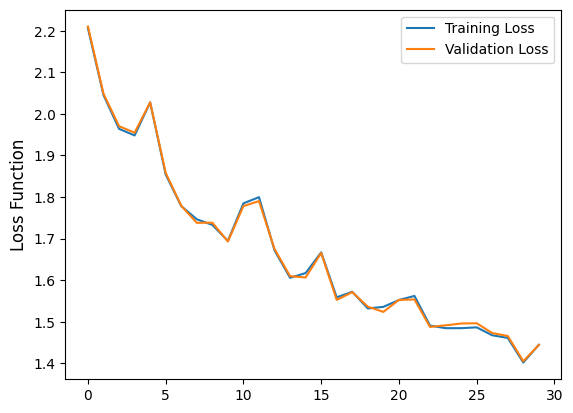

In [15]:
## Plot the training and Loss functions from the original model 
import matplotlib.pyplot as plt

plt.plot(og_train_loss,label='Training Loss')
plt.plot(og_val_loss,label='Validation Loss')

plt.ylabel('Loss Function',fontsize=12)

plt.legend()
plt.show()

In [16]:
acc = np.loadtxt('accurrraies.txt')
acc_train = acc[0]
acc_test = acc[1]

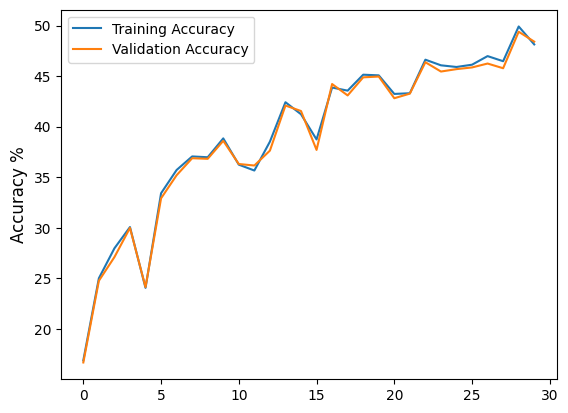

In [17]:
## Plot the training and Loss functions from the original model 
import matplotlib.pyplot as plt

plt.plot(acc_train,label='Training Accuracy')
plt.plot(acc_test,label='Validation Accuracy')

plt.ylabel('Accuracy %',fontsize=12)

plt.legend()
plt.show()

In [18]:
## Define downsampler, Convoluiton bloks and Classifier_HW

from torch import nn


class HW_Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(HW_Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):


        return self.downsample(self.norm(inputs))
        
        

class HW_ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(HW_ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)
        
        #self.dropout = nn.Dropout()  # Adding Dropout layer

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )
        
        self.dropout = nn.Dropout()  # Adding Dropout layer
        
        # Two more convolutions:
        self.conv4 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)
        
        self.dropout = nn.Dropout()  # Adding Dropout layer

        self.conv5 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )
        
        self.dropout = nn.Dropout()  # Adding Dropout layer
        

    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)
        
        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)
        
        x = self.conv4(x)
        
        x = torch.nn.functional.gelu(x)
        
        x = self.conv5(x)

        

        # This makes it a residual network:
        return x + inputs
    

class HW_Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(HW_Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(HW_ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(HW_Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



In [19]:
# ## Prepare train and test data loaders
# import torch, torchvision
# from torchvision.transforms import v2
# training_data = torchvision.datasets.CIFAR10(
#     root="ai-science-training-series/03_advanced_neural_networks/",
#     train=True,
#     download=True,
#     transform=v2.Compose([
#         v2.ToTensor(),
#         v2.RandomHorizontalFlip(), ## Image augmentation list, Do all tihs in a row. 
#         v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
#         v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), ## Adding noise to images 
#     ])
# )

# test_data = torchvision.datasets.CIFAR10(
#     root="ai-science-training-series/03_advanced_neural_networks/",
#     train=False,
#     download=False,
#     transform=torchvision.transforms.ToTensor()
# )

# training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

hw_batch_size = 512 #128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, 
    batch_size=hw_batch_size, 
    pin_memory=True,
    shuffle=True, 
    num_workers=4)
val_dataloader = torch.utils.data.DataLoader(validation_data, 
    batch_size=hw_batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=4)

## Define helper function to Wrapp data and move it to GPU

dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


hw_train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
hw_val_dataloader = WrappedDataLoader(val_dataloader, preprocess)


In [20]:
## Denife parameters for new model
### Define inputs for original model 
hw_initial_filters = 32
hw_n_stages = 2
hw_blocks_per_stage = 2

# Define model
hw_model = HW_Classifier(hw_initial_filters,hw_n_stages,hw_blocks_per_stage)

## Define Loss function and optimizer 
hw_loss_fn = nn.CrossEntropyLoss()
hw_optimizer = torch.optim.AdamW(hw_model.parameters(), lr=0.001, weight_decay=0.01) #


from torchinfo import summary

print(summary(hw_model, input_size=(batch_size, 3, 32, 32)))



Layer (type:depth-idx)                   Output Shape              Param #
HW_Classifier                            [128, 10]                 --
├─Conv2d: 1-1                            [128, 32, 32, 32]         128
├─LayerNorm: 1-2                         [128, 32, 32, 32]         65,536
├─Sequential: 1-3                        [128, 64, 16, 16]         --
│    └─HW_ConvNextBlock: 2-1             [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-2               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-3                  [128, 128, 32, 32]        4,224
│    │    └─Conv2d: 3-4                  [128, 32, 32, 32]         4,128
│    │    └─Conv2d: 3-5                  [128, 128, 32, 32]        4,224
│    │    └─Conv2d: 3-6                  [128, 32, 32, 32]         4,128
│    └─HW_ConvNextBlock: 2-2             [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-7                  [128, 32, 32, 32]   

In [21]:
## train HW model 

## Trian the original model for 30 epock 
from tqdm.notebook import tqdm

#  Initialize list to store 
hw_train_acc = []
hw_train_loss = []
hw_val_acc = []
hw_val_loss = []

epochs = 30
for j in range(epochs):
    with tqdm(total=len(hw_train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(hw_train_dataloader, hw_model, hw_loss_fn, hw_optimizer, train_bar)
    
    # checking on the training loss and accuracy once per epoch
        
    with tqdm(total=len(hw_train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(hw_train_dataloader, hw_model, hw_loss_fn, train_eval)
        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc/5:.3f}")
        
        # Append values to lists
        hw_train_acc.append(acc/5)
        hw_train_loss.append(loss)
        
    with tqdm(total=len(hw_val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
        acc_val, loss_val = evaluate(hw_val_dataloader, hw_model, hw_loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val/5:.3f}")
    
        # Append values to list 
        hw_val_acc.append(acc_val/5)
        hw_val_loss.append(loss_val)
        


Train Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: training loss: 1.959, accuracy: 21.855


Validate Epoch 0:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.951, accuracy: 21.875


Train Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: training loss: 1.696, accuracy: 30.075


Validate Epoch 1:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.691, accuracy: 29.578


Train Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: training loss: 1.600, accuracy: 32.302


Validate Epoch 2:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.591, accuracy: 32.086


Train Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: training loss: 1.522, accuracy: 34.472


Validate Epoch 3:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.509, accuracy: 33.961


Train Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: training loss: 1.466, accuracy: 37.201


Validate Epoch 4:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.459, accuracy: 36.648


Train Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: training loss: 1.390, accuracy: 39.331


Validate Epoch 5:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.380, accuracy: 39.133


Train Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: training loss: 1.248, accuracy: 43.655


Validate Epoch 6:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6: validation loss: 1.247, accuracy: 42.898


Train Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: training loss: 1.267, accuracy: 43.580


Validate Epoch 7:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7: validation loss: 1.278, accuracy: 42.820


Train Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: training loss: 1.160, accuracy: 46.345


Validate Epoch 8:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8: validation loss: 1.174, accuracy: 44.883


Train Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: training loss: 1.234, accuracy: 45.002


Validate Epoch 9:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9: validation loss: 1.250, accuracy: 44.125


Train Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: training loss: 1.068, accuracy: 49.011


Validate Epoch 10:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.083, accuracy: 47.562


Train Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: training loss: 1.049, accuracy: 49.907


Validate Epoch 11:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11: validation loss: 1.067, accuracy: 48.477


Train Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: training loss: 0.968, accuracy: 52.278


Validate Epoch 12:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.989, accuracy: 50.398


Train Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: training loss: 0.938, accuracy: 52.939


Validate Epoch 13:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.976, accuracy: 51.031


Train Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: training loss: 0.921, accuracy: 53.509


Validate Epoch 14:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.956, accuracy: 51.906


Train Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: training loss: 0.895, accuracy: 54.403


Validate Epoch 15:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.931, accuracy: 52.320


Train Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: training loss: 0.902, accuracy: 53.426


Validate Epoch 16:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.944, accuracy: 51.250


Train Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: training loss: 0.811, accuracy: 56.454


Validate Epoch 17:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.867, accuracy: 54.203


Train Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: training loss: 0.773, accuracy: 57.828


Validate Epoch 18:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.839, accuracy: 55.172


Train Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: training loss: 0.771, accuracy: 57.761


Validate Epoch 19:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.840, accuracy: 55.031


Train Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: training loss: 0.750, accuracy: 58.337


Validate Epoch 20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20: validation loss: 0.836, accuracy: 55.508


Train Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: training loss: 0.751, accuracy: 58.026


Validate Epoch 21:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21: validation loss: 0.850, accuracy: 54.555


Train Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: training loss: 0.700, accuracy: 59.860


Validate Epoch 22:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22: validation loss: 0.784, accuracy: 56.641


Train Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: training loss: 0.665, accuracy: 60.839


Validate Epoch 23:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23: validation loss: 0.762, accuracy: 57.297


Train Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: training loss: 0.669, accuracy: 60.530


Validate Epoch 24:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24: validation loss: 0.776, accuracy: 57.078


Train Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: training loss: 0.645, accuracy: 61.377


Validate Epoch 25:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25: validation loss: 0.754, accuracy: 57.750


Train Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: training loss: 0.616, accuracy: 62.223


Validate Epoch 26:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26: validation loss: 0.739, accuracy: 57.914


Train Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: training loss: 0.643, accuracy: 61.586


Validate Epoch 27:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27: validation loss: 0.757, accuracy: 57.719


Train Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: training loss: 0.587, accuracy: 62.945


Validate Epoch 28:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28: validation loss: 0.695, accuracy: 59.578


Train Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Validate (train) Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: training loss: 0.596, accuracy: 62.498


Validate Epoch 29:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29: validation loss: 0.710, accuracy: 58.445


In [22]:
## Save values to lists
import numpy as np

np.savetxt('hw_loss_functions.txt',[hw_train_loss,hw_val_loss])
np.savetxt('hw_accurrraies.txt',[hw_train_acc,hw_val_acc])

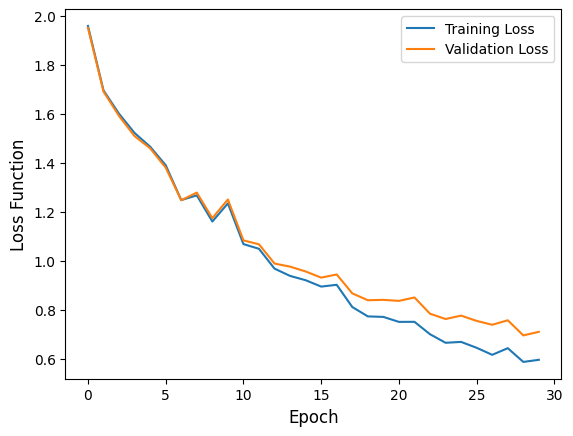

In [31]:
## Plot the training and Loss functions from the original model 
import matplotlib.pyplot as plt

plt.plot(hw_train_loss,label='Training Loss')
plt.plot(hw_val_loss,label='Validation Loss')

plt.ylabel('Loss Function',fontsize=12)
plt.xlabel('Epoch',fontsize=12)

plt.legend()
plt.show()

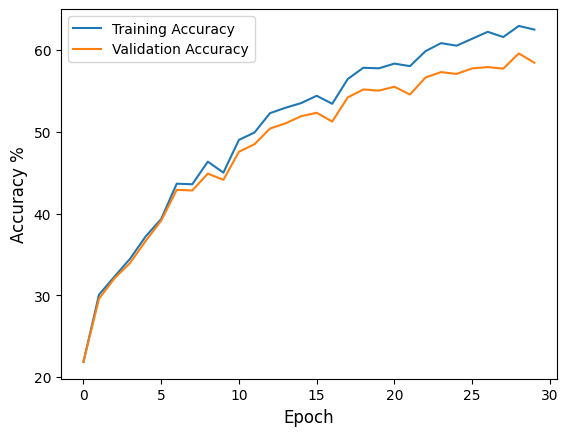

In [32]:
## Plot the training and Loss functions from the original model 
import matplotlib.pyplot as plt

plt.plot(hw_train_acc,label='Training Accuracy')
plt.plot(hw_val_acc,label='Validation Accuracy')

plt.ylabel('Accuracy %',fontsize=12)
plt.xlabel('Epoch',fontsize=12)

plt.legend()
plt.show()

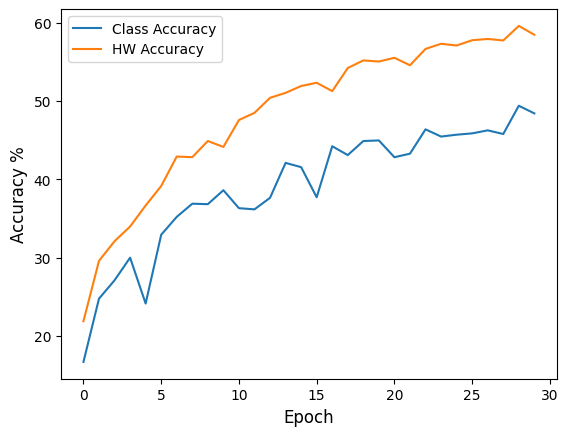

In [30]:
## COmpare Class accuracy to HW accuracy 

## Plot the training and Loss functions from the original model 
import matplotlib.pyplot as plt

plt.plot(acc_test,label='Class Accuracy')
plt.plot(hw_val_acc,label='HW Accuracy')

plt.ylabel('Accuracy %',fontsize=12)
plt.xlabel('Epoch',fontsize=12)

plt.legend()
plt.show()


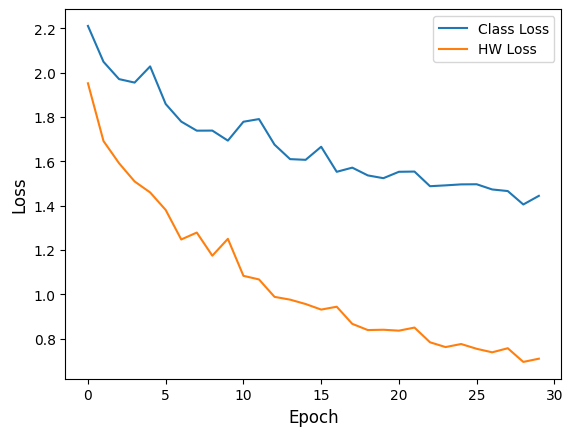

In [29]:
## COmpare Class accuracy to HW accuracy 

## Plot the training and Loss functions from the original model 
import matplotlib.pyplot as plt

plt.plot(og_val_loss,label='Class Loss')
plt.plot(hw_val_loss,label='HW Loss')

plt.ylabel('Loss',fontsize=12)
plt.xlabel('Epoch',fontsize=12)

plt.legend()
plt.show()


## Discussion


And compare your final validation accuracy to the accuracy shown here.  Can you beat the validation accuracy shown?

For full credit on the homework, you need to show (via text, or make a plot) the training and validation data sets' performance (loss and accuracy) for all the epochs you train.  You also need to explain, in several sentences, what you changed in the network and why you think it makes a difference.


The main changes to the neural network were the addition of three (3) 2d convolutions on the ConvNextBlock class and a dropout layer between the added convolutions with a 0.5 probability. The added convolutions generated a deeper convolution block, which could improve the feature extraction capabilities of the NN. However, since several convolutions were and, I opted to add the dropout layers to reduce the chances of overfitting when training the model due to the number of convolutions. Additionally, I used the AdamW optimizer and a learning rate of 0.001., This optimizer is more efficient than the SGD used in class, and this allowed a better minimization of the loss function, resulting in a more accurate model. The final change made during training is the increase of the batch size to be 4 times the batch size used during class (128x4=512). This also helped optimize the weight of the loss function.

These modifications to the model's architecture allowed me to train more accurate models using a significantly smaller model. The training results show signs of overfitting, but hyperparameter optimization can be conducted to obtain a better overlapping of the training and validation loss functions. 